# Full-Sequence Panorama Construction
This notebook extends our 2-image homography example to the complete ordered sequence in a folder.

## Pipeline
1. Load and sort images from a folder.
2. Detect keypoints/descriptors (SIFT).
3. Match descriptors between consecutive pairs using Lowe's ratio test.
4. Estimate pairwise homographies with RANSAC (consecutive frames).
5. Chain homographies to a reference frame (center image) to minimize distortion.
6. Warp all images into the common reference coordinate system.
7. Perform simple Gaussian-weighted blending to form the panorama.

In [1]:
# Global imports and configuration
# !pip install -r ../requirements.txt
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pillow_heif import register_heif_opener
register_heif_opener()
from typing import List, Dict
from PIL import Image, ImageOps

plt.rcParams['figure.figsize'] = [15, 10]
np.set_printoptions(precision=3, suppress=True)

### 1. Load, Sort and Resize Images

### Configuration: Feature Detector Selection
Choose between SIFT and ORB feature detectors. SIFT is better for translation scenarios while ORB works well for rotation scenarios.

In [2]:
# MAX_WIDTH = 1280
# MAX_HEIGHT = 720
image_folder = '../data/coffee_scene_nopuff/'
# image_folder = '../data/coffee_rotate_scene_2/'


images: List[np.ndarray] = []
image_names: List[str] = []

print(f'Searching images in: {os.path.abspath(image_folder)}')
for filename in sorted(os.listdir(image_folder)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.heic')):
        p = os.path.join(image_folder, filename)
        img = None
        
        # Tenta carregar com OpenCV primeiro (para formatos suportados)
        if not filename.lower().endswith('.heic'):
            img = cv2.imread(p)
        
        # Se OpenCV falhou ou é um arquivo HEIC, tenta com Pillow
        if img is None:
            try:
                pil_img = Image.open(os.path.abspath(p))
                # Corrige orientação baseada em EXIF (importante para HEIC)
                pil_img = ImageOps.exif_transpose(pil_img)
                # Converte para RGB se necessário
                if pil_img.mode != 'RGB':
                    pil_img = pil_img.convert('RGB')
                # Converte PIL para OpenCV (BGR)
                img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
            except Exception as e:
                print(f'Falha ao carregar {filename} com Pillow: {e}')
                continue
        
        if img is not None:
            images.append(img)
            image_names.append(filename)
        else:
            print(f'Falha ao carregar: {filename}')

# images = images[:5]
print(f'Total de imagens carregadas: {len(images)}')
assert len(images) >= 2, 'At least 2 images are required.'

Searching images in: /home/eduardo/MO446_T1/data/coffee_scene_nopuff
Total de imagens carregadas: 9


In [3]:
# Configuration: Choose feature detector
# Options: 'SIFT' or 'ORB'
# Set to None for automatic detection based on folder name
DETECTOR_TYPE = None  # Set to 'SIFT' or 'ORB' to force a specific detector

# Automatic detection based on folder name
if DETECTOR_TYPE is None:
    if 'coffee_rotate' in image_folder:
        DETECTOR_TYPE = 'ORB'
        print(f"Auto-detected rotation scenario, using {DETECTOR_TYPE}")
    else:
        DETECTOR_TYPE = 'SIFT'
        print(f"Auto-detected translation scenario, using {DETECTOR_TYPE}")
else:
    print(f"Manual selection: {DETECTOR_TYPE}")

print(f"Final detector selection: {DETECTOR_TYPE}")
print()
print("💡 Tip: For translation scenarios use SIFT, for rotation scenarios use ORB")
print("   You can manually set DETECTOR_TYPE = 'SIFT' or 'ORB' to override auto-detection")

Auto-detected translation scenario, using SIFT
Final detector selection: SIFT

💡 Tip: For translation scenarios use SIFT, for rotation scenarios use ORB
   You can manually set DETECTOR_TYPE = 'SIFT' or 'ORB' to override auto-detection


### 2. Detect Local Features (SIFT or ORB)
We extract keypoints using either SIFT or ORB based on the configuration above:
- **SIFT**: Scale- and rotation-invariant, 128-D descriptors. Better for translation scenarios.
- **ORB**: Binary descriptors, faster computation. Works well for rotation scenarios.

Design considerations:
- nfeatures limits max keypoints to control runtime.
- Contrast/edge thresholds could be tuned for low-texture scenes.
- Matcher type depends on descriptor type (FLANN for SIFT, BruteForce for ORB).

In [4]:
# Initialize detector and matcher based on configuration
if DETECTOR_TYPE == 'SIFT':
    # SIFT detector with FLANN matcher
    detector = cv2.SIFT_create(nfeatures=12000)
    
    # FLANN for SIFT descriptors (float32) using KDTree
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    
    ratio_thresh = 0.25  # Lowe's ratio threshold for SIFT
    
elif DETECTOR_TYPE == 'ORB':
    # ORB detector with BruteForce matcher
    detector = cv2.ORB_create(nfeatures=12000)
    
    # BruteForce matcher for ORB descriptors (binary)
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    
    ratio_thresh = 0.75  # Higher threshold for ORB binary descriptors
    
else:
    raise ValueError(f"Unsupported detector type: {DETECTOR_TYPE}")

print(f"Initialized {DETECTOR_TYPE} detector with appropriate matcher")

Initialized SIFT detector with appropriate matcher


In [5]:
def detect_all_features(imgs: List[np.ndarray]) -> List[Dict]:
    """Detect keypoints/descriptors for all images using the configured detector.

    Returns a list of dicts with keys: 'image', 'gray', 'kp', 'desc'.
    """
    data = []
    for i, im in enumerate(imgs):
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        kp, desc = detector.detectAndCompute(gray, None)
        data.append({'image': im, 'gray': gray, 'kp': kp, 'desc': desc})
        desc_info = f"{desc.shape} ({desc.dtype})" if desc is not None else "None"
        print(f'Image {i}: {image_names[i]} | keypoints: {len(kp)} | desc: {desc_info}')
    return data

dataset = detect_all_features(images)
print(f'Dataset created with {len(dataset)} images using {DETECTOR_TYPE} detector.')

Image 0: IMG_3187.HEIC | keypoints: 12000 | desc: (12000, 128) (float32)
Image 1: IMG_3188.HEIC | keypoints: 12000 | desc: (12000, 128) (float32)
Image 2: IMG_3189.HEIC | keypoints: 12000 | desc: (12000, 128) (float32)
Image 3: IMG_3190.HEIC | keypoints: 12000 | desc: (12000, 128) (float32)
Image 4: IMG_3191.HEIC | keypoints: 12000 | desc: (12000, 128) (float32)
Image 5: IMG_3192.HEIC | keypoints: 12000 | desc: (12000, 128) (float32)
Image 6: IMG_3193.HEIC | keypoints: 12000 | desc: (12000, 128) (float32)
Image 7: IMG_3194.HEIC | keypoints: 12000 | desc: (12000, 128) (float32)
Image 8: IMG_3195.HEIC | keypoints: 12001 | desc: (12001, 128) (float32)
Dataset created with 9 images using SIFT detector.


### 3. Match Consecutive Image Pairs
We perform descriptor matching only between consecutive frames to keep graph topology simple (a path). For each descriptor in image i we retrieve its 2 nearest neighbors in image i+1 and apply Lowe's ratio test.

Rationale:
- Restricting to adjacent images reduces false matches and runtime.
- Full graph matching (all-vs-all) improves robustness for unordered sets but is O(N^2).
- Lowe ratio threshold (typical 0.7–0.9) trades precision vs recall.

In [6]:
K = 2  # Use 2 for standard ratio test (was 3 before)

def match_pair(desc1: np.ndarray, desc2: np.ndarray):
    """Return list of good matches between two descriptor sets using KNN + Lowe ratio test."""
    if desc1 is None or desc2 is None:
        return []
    
    # KNN matching with appropriate matcher
    if DETECTOR_TYPE == 'SIFT':
        # FLANN matcher for SIFT
        knn = matcher.knnMatch(desc1, desc2, k=K)
    else:  # ORB
        # BruteForce matcher for ORB
        knn = matcher.knnMatch(desc1, desc2, k=K)
    
    # Apply Lowe's ratio test
    good = []
    for match_pair in knn:
        if len(match_pair) == 2:  # Ensure we have 2 matches
            m, n = match_pair
            if m.distance < ratio_thresh * n.distance:
                good.append(m)
    
    return good

pairs_matches = []
for i in range(len(dataset) - 1):
    m = match_pair(dataset[i]['desc'], dataset[i+1]['desc'])
    print(f'Pair ({i},{i+1}) -> filtered matches: {len(m)}')
    pairs_matches.append(m)

# Quick sanity check
assert all(len(m) >= 4 for m in pairs_matches), 'A pair has insufficient matches (>=4 required) for homography.'

Pair (0,1) -> filtered matches: 113
Pair (1,2) -> filtered matches: 30
Pair (2,3) -> filtered matches: 30
Pair (3,4) -> filtered matches: 34
Pair (4,5) -> filtered matches: 106
Pair (5,6) -> filtered matches: 46
Pair (6,7) -> filtered matches: 80
Pair (7,8) -> filtered matches: 66


### 4. Estimate Pairwise Homographies (RANSAC)
Using the filtered matches for each adjacent pair we compute a projective transform (3x3 homography) with RANSAC to reject outliers.

Parameters:
- ransacReprojThreshold: maximum reprojection error (pixels) to count as inlier.
- maxIters, confidence: control robustness vs speed.

Failure modes:
- Too few inliers (low texture / motion blur).
- Pure rotation + low parallax may still produce valid H but can amplify drift when chaining.

In [7]:
def estimate_homography_between(i: int, j: int):
    """Estimate homography mapping image i to image j (only consecutive supported)."""
    kpA, kpB = dataset[i]['kp'], dataset[j]['kp']
    matches = pairs_matches[i] if j == i+1 else None
    if matches is None:
        raise ValueError('This example only estimates between consecutive pairs.')
    ptsA = np.float32([kpA[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    ptsB = np.float32([kpB[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    H, inliers = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC, ransacReprojThreshold=1.5, maxIters=50000, confidence=0.9995)
    if H is None:
        raise RuntimeError(f'Failed to estimate H between {i}->{j}')
    nin = int(inliers.sum()) if inliers is not None else 0
    print(f'H {i}->{j} estimated. Inliers: {nin}/{len(matches)}')
    return H

# H_forward[i] maps i -> i+1
H_forward: List[np.ndarray] = []
for i in range(len(dataset) - 1):
    H = estimate_homography_between(i, i+1)
    H = H / H[2,2]
    print(f'H_{i}->{i+1}:{H}')
    H_forward.append(H)

H 0->1 estimated. Inliers: 35/113
H_0->1:[[   1.027    0.022 -249.352]
 [   0.004    1.022  -23.936]
 [   0.       0.       1.   ]]
H 1->2 estimated. Inliers: 11/30
H_1->2:[[   0.969    0.006 -151.229]
 [  -0.015    0.982   12.134]
 [  -0.       0.       1.   ]]
H 2->3 estimated. Inliers: 10/30
H_2->3:[[   1.063    0.036 -492.799]
 [   0.009    1.015  -22.474]
 [   0.       0.       1.   ]]
H 3->4 estimated. Inliers: 12/34
H_3->4:[[   0.957   -0.025 -226.138]
 [   0.       0.948   37.787]
 [  -0.      -0.       1.   ]]
H 4->5 estimated. Inliers: 32/106
H_4->5:[[   1.014    0.036 -293.353]
 [  -0.009    1.002    7.244]
 [   0.      -0.       1.   ]]
H 5->6 estimated. Inliers: 20/46
H_5->6:[[   1.002    0.006 -234.45 ]
 [   0.003    1.005   -1.179]
 [   0.       0.       1.   ]]
H 6->7 estimated. Inliers: 21/80
H_6->7:[[   1.032    0.012 -301.561]
 [   0.011    1.032  -19.317]
 [   0.       0.       1.   ]]
H 7->8 estimated. Inliers: 23/66
H_7->8:[[   0.966    0.015 -180.134]
 [  -0.01  

### 5. Chain Homographies to a Reference Frame
We choose the middle image as reference to minimize perspective distortion and accumulated drift. For images left of the reference we compose forward homographies; for the right side we compose then invert.

Alternative strategies:
- Global bundle adjustment optimizing all homographies simultaneously.
- Selecting a frame with minimal average distance to others (graph center).

In [8]:
def chain_homographies_to_ref(n: int, ref_idx: int, H_forward: List[np.ndarray]) -> List[np.ndarray]:
    """Return list H_to_ref[k]: homography mapping image k into reference frame ref_idx."""
    I = np.eye(3, dtype=np.float64)
    H_to_ref = [I.copy() for _ in range(n)]
    # For k < ref: multiply forward (k->k+1->...->ref)
    for k in range(ref_idx - 1, -1, -1):
        # H_to_ref[k] = H_forward[k] @ H_to_ref[k+1]
        # H_to_ref[k] = H_forward[k+1] @ H_to_ref[k]
        H_to_ref[k] = H_to_ref[k+1] @ H_forward[k]
        H_to_ref[k] /= H_to_ref[k][2,2]
    # For k > ref: chain ref->...->k then invert
    for k in range(ref_idx + 1, n):
        H_ref_to_k = np.eye(3, dtype=np.float64)
        for t in range(ref_idx, k):
            H_ref_to_k = H_forward[t] @ H_ref_to_k
        H_to_ref[k] = np.linalg.inv(H_ref_to_k)
        H_to_ref[k] /= H_to_ref[k][2,2]
    return H_to_ref

ref_idx = len(dataset) // 2  # central image as reference
H_to_ref = chain_homographies_to_ref(len(dataset), ref_idx, H_forward)
print(f'Reference image: {ref_idx} -> {image_names[ref_idx]}')

Reference image: 4 -> IMG_3191.HEIC


#### Computing panorama canvas bounds from warped corners

In [9]:
def compute_panorama_bounds(imgs: List[np.ndarray], H_to_ref: List[np.ndarray]):
    corners_all = []
    for k, img in enumerate(imgs):
        h, w = img.shape[:2]
        corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
        warped = cv2.perspectiveTransform(corners, H_to_ref[k])
        corners_all.append(warped)
    allc = np.vstack(corners_all)
    xmin, ymin = np.floor(allc.min(axis=0).ravel()).astype(int)
    xmax, ymax = np.ceil(allc.max(axis=0).ravel()).astype(int)
    return xmin, ymin, xmax, ymax

xmin, ymin, xmax, ymax = compute_panorama_bounds(images, H_to_ref)
Tx, Ty = -xmin, -ymin
T = np.array([[1,0,Tx],[0,1,Ty],[0,0,1]], dtype=np.float64)
W, Hh = (xmax - xmin), (ymax - ymin)
print(f'Panorama canvas (W x H): {W} x {Hh}')

Panorama canvas (W x H): 5068 x 4253


### 6. Warp Images to Common Reference Frame

In [10]:
folder_name = os.path.basename(os.path.normpath(image_folder))
save_dir = os.path.join('..', 'report', 'figs', 'alignment', folder_name)
os.makedirs(save_dir, exist_ok=True)

print(f'--- Saving progressive alignment figures to: {save_dir} ---')
for k, img in enumerate(images):
    Hk = T @ H_to_ref[k]
    warped_image = cv2.warpPerspective(img, Hk, (W, Hh))
    plt.figure(figsize=(18,10))
    plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Alignment of Image {k}: {image_names[k]}')
    plt.axis('off')
    out_path = os.path.join(save_dir, f'{k:02d}_{os.path.splitext(image_names[k])[0]}.png')
    plt.savefig(out_path, bbox_inches='tight')
    plt.close()
print('Done.')

--- Saving progressive alignment figures to: report/figs/alignment/coffee_scene_nopuff ---
Done.


### 7. Naive Gaussian Blending

In [11]:
SIGMA = 65

# Warp + simple Gaussian-weighted blending
def warp_and_blend(imgs: List[np.ndarray], H_to_ref: List[np.ndarray], T: np.ndarray, size: tuple, sigma: int = 1):
    """Warp all images into panorama canvas and blend with blurred mask weighting."""
    W, Hh = size
    acc = np.zeros((Hh, W, 3), dtype=np.float64)
    wsum = np.zeros((Hh, W, 1), dtype=np.float64)
    for k, img in enumerate(imgs):
        Hk = T @ H_to_ref[k]
        warped = cv2.warpPerspective(img, Hk, (W, Hh))
        mask = np.ones(img.shape[:2], dtype=np.uint8) * 255
        warped_mask = cv2.warpPerspective(mask, Hk, (W, Hh))
        weight = warped_mask.astype(np.float32) / 255.0
        if sigma and sigma > 1:
            ksize = (sigma | 1, sigma | 1)  # ensure odd size
            weight = cv2.GaussianBlur(weight, ksize, 0)
        weight = weight[..., None]
        acc += warped.astype(np.float64) * weight
        wsum += weight
    eps = 1e-6
    out = (acc / (wsum + eps)).clip(0, 255).astype(np.uint8)
    return out

panorama = warp_and_blend(images, H_to_ref, T, (W, Hh), sigma=SIGMA)

# Save panorama figure
final_dir = os.path.join('..', 'report', 'figs', 'final_pano', folder_name)
os.makedirs(final_dir, exist_ok=True)
final_path = os.path.join(final_dir, f'panorama_sigma{SIGMA}.png')
plt.figure(figsize=(18,10))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title(f'Panorama (Gaussian blending, sigma={SIGMA})')
plt.axis('off')
plt.savefig(final_path, bbox_inches='tight')
plt.close()
print(f'Saved panorama to: {final_path}')

Saved panorama to: report/figs/final_pano/coffee_scene_nopuff/panorama_sigma65.png


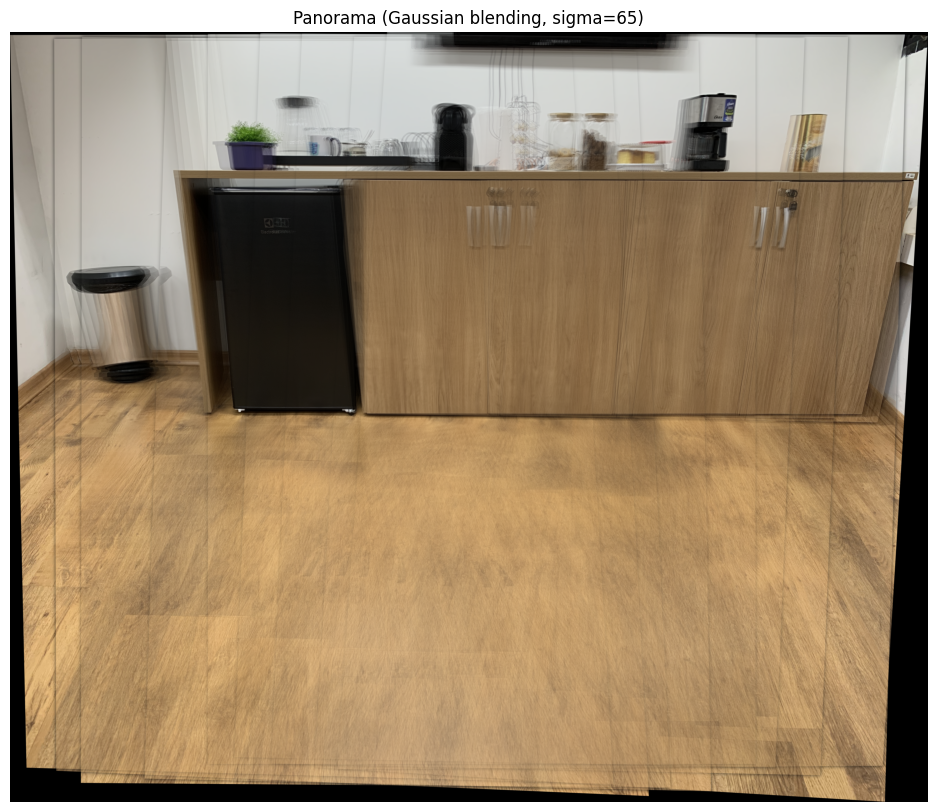

In [12]:
plt.figure(figsize=(18,10))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title(f'Panorama (Gaussian blending, sigma={SIGMA})')
plt.axis('off')
plt.show()